# MELANOMA DETECTION ASSIGNMENT

### PROBLEM STATEMENT:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


### Importing all the important libraries


In [ ]:
# Install Augmentor
!pip install Augmentor

# Import necessary libraries
import pathlib
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
import Augmentor
from google.colab import drive

### Importing Skin Cancer Data

In [ ]:
# Mounting the Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/Dataset/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Dataset/Test')
augmented_data_dir = pathlib.Path("/content/drive/MyDrive/Dataset/AugmentedDataset")

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f"Training Image Count: {image_count_train}")
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f"Testing Image Count: {image_count_test}")

Training Image Count: 2239
Testing Image Count: 118


### Dataset Creation

In [ ]:
# Defining the parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

# Using 80% of the images for training, and 20% for validation.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Creating the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Listing out all the classes of skin cancer and store them in a list
class_names = train_ds.class_names
print(f"Class Names: {class_names}")

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Found 118 files belonging to 9 classes.
Class Names: ['Actinic keratosis', 'Basal cell carcinoma', 'Dermatofibroma', 'Melanoma', 'Nevus', 'Pigmented benign keratosis', 'Seborrheic keratosis', 'Squamous cell carcinoma', 'Vascular lesion']


### Data Visualization

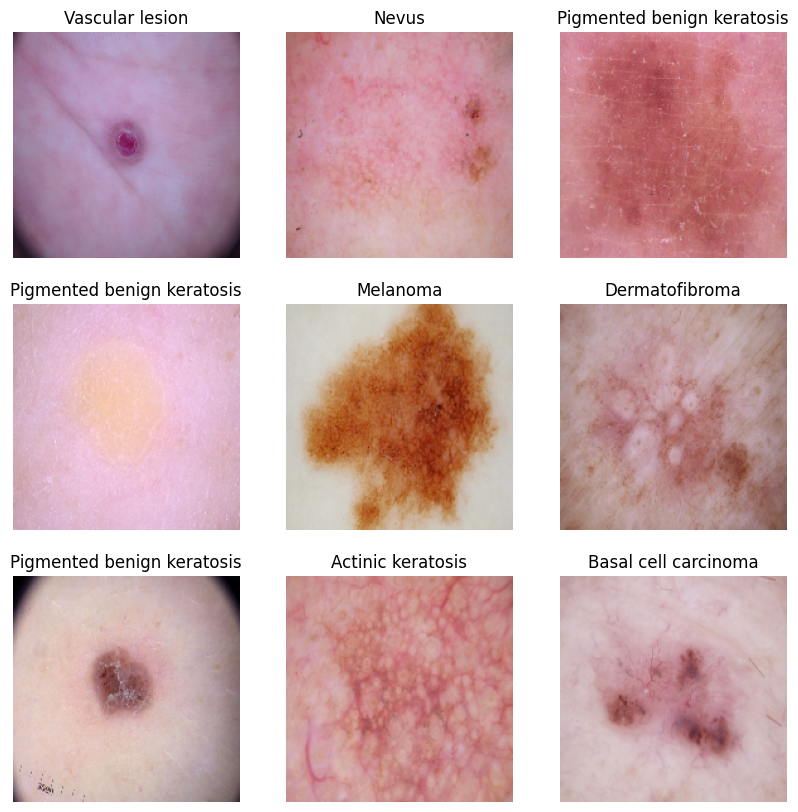

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

### Data Cache and Prefetch

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Creation

In [ ]:
# Creation
def build_model():
    model = Sequential([
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(class_names), activation='softmax')
    ])
    return model

# Compilation
def compile_model(model):
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

# Viewing the summary of all layers
model = build_model()
model = compile_model(model)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

### Model Training

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 129s 559ms/step - loss: 2.1684 - accuracy: 0.2260 - val_loss: 1.9218 - val_accuracy: 0.2953
Epoch 2/20
56/56 [==============================] - 1s 26ms/step - loss: 1.8762 - accuracy: 0.3471 - val_loss: 1.7750 - val_accuracy: 0.3289
Epoch 3/20
56/56 [==============================] - 1s 26ms/step - loss: 1.7412 - accuracy: 0.3834 - val_loss: 1.6493 - val_accuracy: 0.4273
Epoch 4/20
56/56 [==============================] - 1s 26ms/step - loss: 1.6818 - accuracy: 0.4079 - val_loss: 1.6118 - val_accuracy: 0.4698
Epoch 5/20
56/56 [==============================] - 1s 27ms/step - loss: 1.6183 - accuracy: 0.4235 - val_loss: 1.5647 - val_accuracy: 0.4698
Epoch 6/20
56/56 [==============================] - 1s 26ms/step - loss: 1.5286 - accuracy: 0.4710 - val_loss: 1.4562 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 1s 26ms/step - loss: 1.4675 - accuracy: 0.4894 - val_loss: 1.4384 - val_accuracy: 0.5056
Epoch 8/20

### Visualizing training results

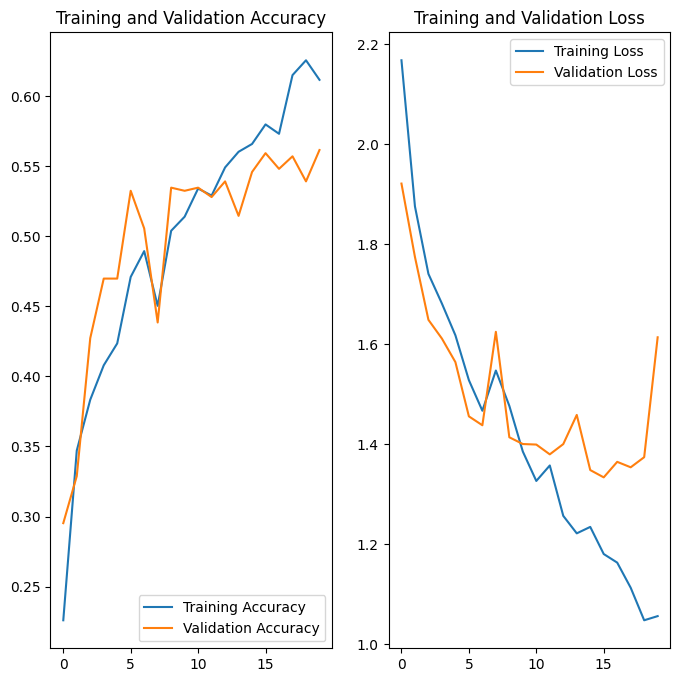

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Evaluating the model on the test dataset
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print(f'\nTest accuracy: {test_acc}')

4/4 - 13s - loss: 3.6811 - accuracy: 0.3644 - 13s/epoch - 3s/step

Test accuracy: 0.3644067943096161


### Findings:
1. The model was relatively simple but showed signs of overfitting.
2. The test accuracy was significantly lower than the validation accuracy, indicating poor generalization.


### Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.Lambda(lambda x: tf.image.random_brightness(x, max_delta=0.1)),
    layers.Lambda(lambda x: tf.image.random_contrast(x, lower=0.9, upper=1.1)),
  ]
)

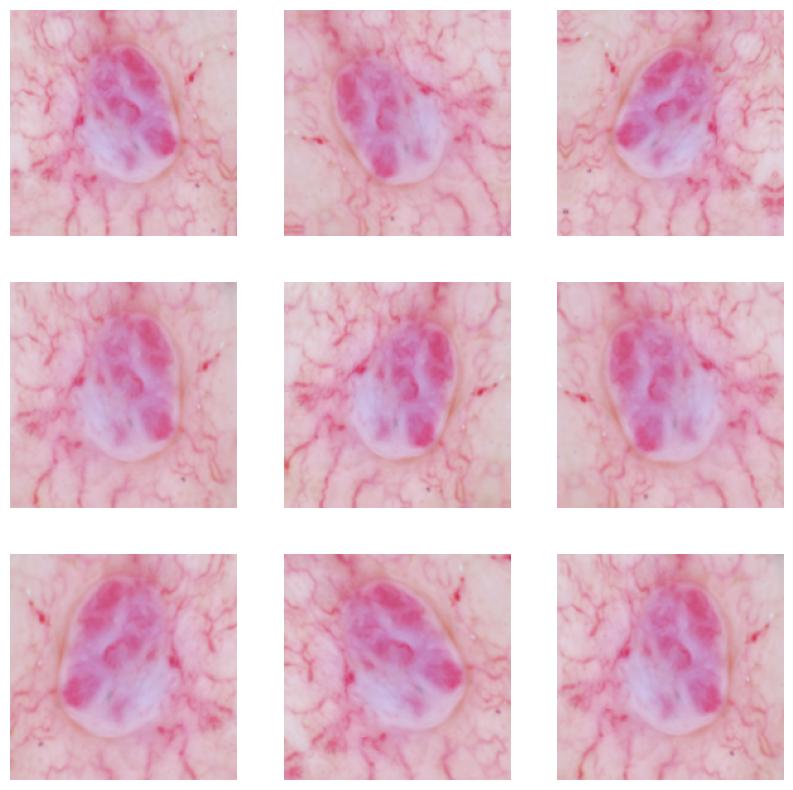

In [ ]:
# Checking the performance of data augmentation strategy
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

### Model Creation

In [ ]:
def build_improved_model():
    model = Sequential([
        data_augmentation,
        layers.experimental.preprocessing.Resizing(img_height, img_width),  # Resizing layer after augmentation
        layers.experimental.preprocessing.Rescaling(1./255),

        layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),

        layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),

        layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.4),

        layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),

        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(len(class_names), activation='softmax')
    ])
    return model

better_model = build_improved_model()
better_model = compile_model(model)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

### Model Training

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = better_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
56/56 [==============================] - 3s 31ms/step - loss: 1.0290 - accuracy: 0.6334 - val_loss: 1.4281 - val_accuracy: 0.5459 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 1s 26ms/step - loss: 0.9262 - accuracy: 0.6635 - val_loss: 1.4914 - val_accuracy: 0.5660 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 1s 27ms/step - loss: 0.9269 - accuracy: 0.6590 - val_loss: 1.3993 - val_accuracy: 0.5660 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 1s 26ms/step - loss: 0.8851 - accuracy: 0.6708 - val_loss: 1.4431 - val_accuracy: 0.5548 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 1s 26ms/step - loss: 0.8492 - accuracy: 0.6814 - val_loss: 1.6038 - val_accuracy: 0.5459 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 1s 26ms/step - loss: 0.8776 - accuracy: 0.6858 - val_loss: 1.5606 - val_accuracy: 0.5817 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 1s 26ms/step - loss: 0.7

### Visualizing training results

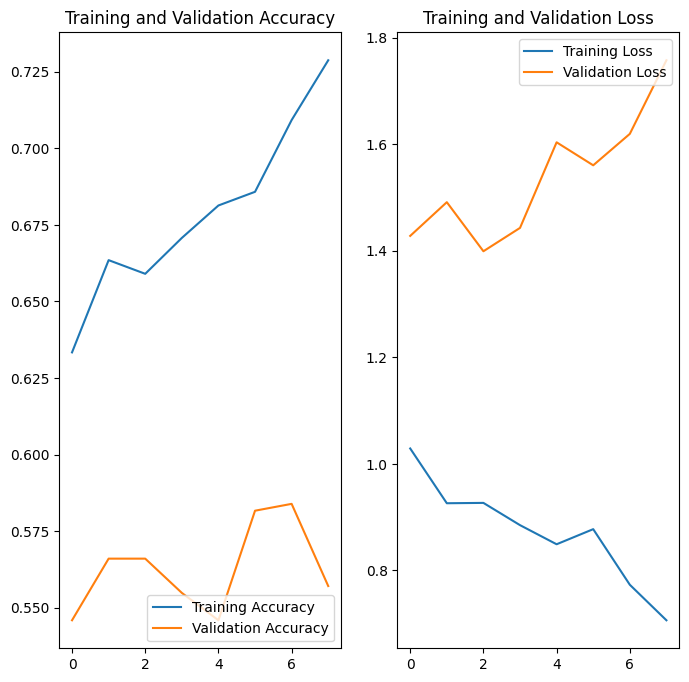

In [ ]:
# Visualizing the training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Evaluating the model on the test dataset
test_loss, test_acc = better_model.evaluate(test_ds, verbose=2)
print(f'\nTest accuracy: {test_acc}')

4/4 - 0s - loss: 2.9797 - accuracy: 0.4407 - 45ms/epoch - 11ms/step

Test accuracy: 0.4406779706478119


### Findings:
1. The model with data augmentation and regularization showed better performance and generalization compared to the basic model.
2. Test accuracy improved but was still significantly lower than validation accuracy, indicating room for improvement in generalization.

### Finding the distribution of classes in the training dataset

In [ ]:
def analyze_class_distribution(dataset):
    class_counts = {}
    for images, labels in dataset.unbatch():
        label = labels.numpy()  # convert the tensor to a numpy value
        class_name = class_names[label]
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1
    return class_counts

class_distribution = analyze_class_distribution(train_ds)
print("Class Distribution in Training Data:", class_distribution)

### Rectification of Class imbalances

In [ ]:
def augment_data_balanced(class_names, source_dir, target_dir, sample_size=500):
    for class_name in class_names:
        p = Augmentor.Pipeline(source_directory=str(source_dir / class_name), output_directory=str(target_dir / class_name))
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.flip_left_right(probability=0.5)
        p.zoom_random(probability=0.5, percentage_area=0.8)
        p.random_contrast(probability=0.5, min_factor=0.7, max_factor=1.3)
        p.random_brightness(probability=0.5, min_factor=0.7, max_factor=1.3)
        p.sample(sample_size)

augment_data_balanced(class_names, data_dir_train, augmented_data_dir, sample_size=500)


Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Dataset/AugmentedDataset/Actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EA57829FFD0>: 100%|██████████| 500/500 [00:08<00:00, 61.34 Samples/s] 


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Dataset/AugmentedDataset/Basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EA5781A1FC0>: 100%|██████████| 500/500 [00:05<00:00, 90.85 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EA57829F5B0>: 100%|██████████| 500/500 [00:05<00:00, 84.59 Samples/s] 


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Dataset/AugmentedDataset/Melanoma.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EA55BF0BCA0>: 100%|██████████| 500/500 [00:23<00:00, 21.70 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Dataset/AugmentedDataset/Nevus.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EA6262B26E0>: 100%|██████████| 500/500 [00:18<00:00, 26.46 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Dataset/AugmentedDataset/Pigmented benign keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EA55BF42080>: 100%|██████████| 500/500 [00:05<00:00, 93.27 Samples/s] 


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Dataset/AugmentedDataset/Seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EA57811EBC0>: 100%|██████████| 500/500 [00:10<00:00, 49.00 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Dataset/AugmentedDataset/Squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EA55BF37970>: 100%|██████████| 500/500 [00:05<00:00, 86.35 Samples/s] 


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Dataset/AugmentedDataset/Vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EA57829FAC0>: 100%|██████████| 500/500 [00:06<00:00, 81.58 Samples/s] 


### Dataset Creation

In [ ]:
# Training Dataset Creation
augmented_train_ds = image_dataset_from_directory(
    augmented_data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

augmented_val_ds = image_dataset_from_directory(
    augmented_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

AUTOTUNE = tf.data.experimental.AUTOTUNE
augmented_train_ds = augmented_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
augmented_val_ds = augmented_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.
Found 4500 files belonging to 9 classes.
Using 900 files for validation.


### Model Creation

In [ ]:
def build_improved_model():
    model = Sequential([
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),

        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),

        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.4),

        layers.Conv2D(256, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),

        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(len(class_names), activation='softmax')
    ])
    optimizer = optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

improved_model = build_improved_model()
improved_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_12 (Ba  (None, 180, 180, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 64)       

### Model Training

In [10]:
class_distribution = analyze_class_distribution(augmented_train_ds)
total_count = sum(class_distribution.values())
class_weights = {i: total_count/class_distribution[class_name] for i, class_name in enumerate(class_names)}

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

history = improved_model.fit(
  augmented_train_ds,
  validation_data=augmented_val_ds,
  epochs=30,
  callbacks=[early_stopping, reduce_lr],
  class_weight=class_weights
)

Epoch 1/30
225/225 [==============================] - 78s 310ms/step - loss: 20.0258 - accuracy: 0.2529 - val_loss: 4.9879 - val_accuracy: 0.1217 - lr: 1.0000e-04
Epoch 2/30
225/225 [==============================] - 11s 50ms/step - loss: 18.3093 - accuracy: 0.3264 - val_loss: 4.7404 - val_accuracy: 0.1994 - lr: 1.0000e-04
Epoch 3/30
225/225 [==============================] - 11s 50ms/step - loss: 17.5156 - accuracy: 0.3556 - val_loss: 4.2156 - val_accuracy: 0.3233 - lr: 1.0000e-04
Epoch 4/30
225/225 [==============================] - 11s 50ms/step - loss: 17.0114 - accuracy: 0.3718 - val_loss: 3.9623 - val_accuracy: 0.3739 - lr: 1.0000e-04
Epoch 5/30
225/225 [==============================] - 11s 50ms/step - loss: 16.5868 - accuracy: 0.4019 - val_loss: 3.8629 - val_accuracy: 0.4011 - lr: 1.0000e-04
Epoch 6/30
225/225 [==============================] - 11s 50ms/step - loss: 16.1585 - accuracy: 0.4149 - val_loss: 3.8980 - val_accuracy: 0.3950 - lr: 1.0000e-04
Epoch 7/30
225/225 [=======

### Visualizing training results

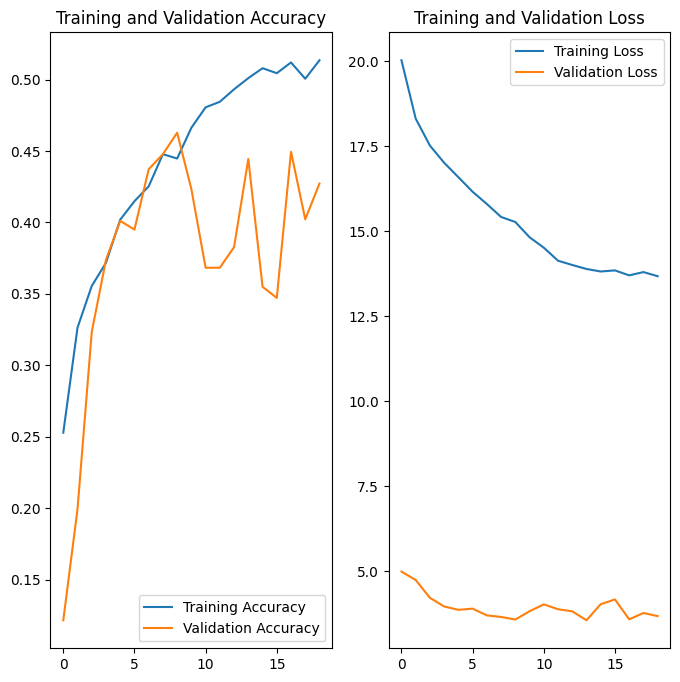

In [11]:
# Visualizing training results (Third model)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings:
1. This model showed better generalization with augmented and balanced data, but overfitting persisted.
2. Although the training accuracy improved, the validation and test accuracies were not as high as desired.
3. The use of class weights helped address class imbalance but did not fully solve generalization issues.

### Evaluting the model for the test dataset

In [12]:
# Evaluating the model on the test dataset
test_loss, test_acc = improved_model.evaluate(test_ds, verbose=2)
print(f'\nTest accuracy: {test_acc}')

4/4 - 9s - loss: 4.9886 - accuracy: 0.2881 - 9s/epoch - 2s/step

Test accuracy: 0.2881355881690979
